### **gensim_w2v_classification : Solution**


- In this exercise, you are going to classify whether a given text belongs to one of possible classes ['BUSINESS', 'SPORTS', 'CRIME'].

- you are going to use **spacy for pre-processing** the text and **gensim to convert text to numbers** and apply different classification algorithms.

In [2]:
#uncomment the below line and run this cell to install the large english model which is trained on wikipedia data

# !python -m spacy download en_core_web_lg

In [4]:
#import api from gensim downloader module


import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

### **About Data: News Category Classifier**

Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65


- This data consists of two columns.
        - Text
        - Category
- Text are the description about a particular topic.
- Category determine which class the text belongs to.
- we have classes mainly of 'BUSINESS', 'SPORTS', 'CRIME' and comes under **Multi-class** classification Problem.

In [7]:
#import pandas library
import pandas as pd


#read the dataset "news_dataset.json" provided and load it into dataframe "df"
df = pd.read_json('news_dataset.json')

#print the shape of data
print(df.shape)

#print the top5 rows
df.head()

(7500, 2)


,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [8]:
#check the distribution of labels 
df['category'].value_counts()

CRIME       2500
SPORTS      2500
BUSINESS    2500
Name: category, dtype: int64

In [9]:
#Add the new column which gives a unique number to each of these labels 
df['label_num'] = df['category'].map({'CRIME': 0, 'SPORTS': 1, 'BUSINESS': 2})


#check the results with top 5 rows
df.head(5) 

,text,category,label_num
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1
3,This Richard Sherman Interception Literally Sh...,SPORTS,1
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2


### Now we will convert the text into a vector using gensim's word2vec embeddings.
### We will do this in three steps,

- 1. Preprocess the text to remove stop words, punctuations and get lemma for each word.

- 2. Get word vectors for each of the words in a pre-processed sentence.

- 3. Take a mean of all word vectors to derive the numeric representation of the entire news article

In [10]:
#use this utility function to get the pre-processed text.

import spacy
nlp = spacy.load("en_core_web_lg") # if this fails then run "python -m spacy download en_core_web_lg" to download that model

def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return wv.get_mean_vector(filtered_tokens)

In [11]:
#create a new column "vector" that store the vector representation of text

df['vector'] = df['text'].apply(lambda text: preprocess_and_vectorize(text))

In [12]:
# print the top 5 rows

df.head()

,text,category,label_num,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,"[0.0062062526, 0.007499068, -0.0018321582, 0.0..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,"[0.011932425, 0.043185577, 0.005834251, 0.0292..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,"[0.026129723, 0.018022463, 0.006559925, 0.0110..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,"[0.021925448, -0.00023149428, -0.022482838, 0...."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,"[0.036470134, -0.023180826, 0.006566672, 0.030..."


**Train-Test splitting**

In [13]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values, 
    df.label_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

**Reshaping the X_train and X_test so as to fit for models**

In [14]:
import numpy as np

print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (6000,)
Shape of X_test before reshaping:  (1500,)
Shape of X_train after reshaping:  (6000, 300)
Shape of X_test after reshaping:  (1500, 300)


**Attempt 1:**


- use gensim embeddings for text vectorization.

- use Decision Tree as the classifier.

- print the classification report.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


#1. creating a Decision Tree model object
clf = DecisionTreeClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       500
           1       0.69      0.64      0.66       500
           2       0.69      0.72      0.70       500

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500



**Attempt 2:**


- use gensim embeddings for text vectorization.
- use MultinomialNB as the classifier after applying the MinMaxscaler.
- print the classification report.

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


#doing scaling because Negative values will not pass into Naive Bayes models
scaler = MinMaxScaler()                                         
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

#1. creating a MultinomialNB model object 
clf = MultinomialNB()

#2. fit with all_train_embeddings and y_train
clf.fit(scaled_train_embed , y_train) 


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(scaled_test_embed)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       500
           1       0.91      0.86      0.88       500
           2       0.88      0.91      0.89       500

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



**Attempt 3:**


- use gensim embeddings for text vectorization.
- use KNeighborsClassifier as the classifier.
- print the classification report.

In [18]:
from  sklearn.neighbors import KNeighborsClassifier


#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       500
           1       0.95      0.83      0.89       500
           2       0.89      0.91      0.90       500

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



**Attempt 4:**


- use gensim embeddings for text vectorization.
- use RandomForestClassifier as the classifier.
- print the classification report.

In [19]:
from sklearn.ensemble import RandomForestClassifier


#1. creating a Random Forest model object
clf = RandomForestClassifier()


#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       500
           1       0.89      0.86      0.87       500
           2       0.89      0.89      0.89       500

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



**Attempt 5:**


- use gensim embeddings for text vectorization.
- use GradientBoostingClassifier as the classifier.
- print the classification report.

In [20]:
from sklearn.ensemble import GradientBoostingClassifier


#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       500
           1       0.91      0.86      0.89       500
           2       0.91      0.91      0.91       500

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



**Print the confusion Matrix with the best model got**

Text(69.0, 0.5, 'Truth')

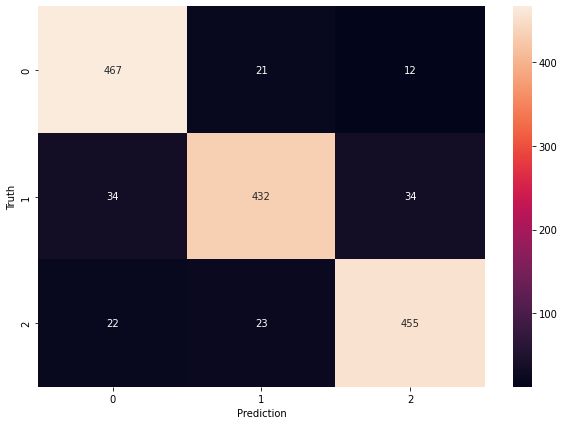

In [21]:
#finally print the confusion matrix for the best model: GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')